In [ ]:
import IPython as ip

# Lecture 4: Basic typeclasses: Monoid. Functor. Applicative

- Math in programming
    - [Semigroup](http://hackage.haskell.org/package/base/docs/Data-Semigroup.html#t:Semigroup) and [Monoid](http://hackage.haskell.org/package/base/docs/Data-Monoid.html#t:Monoid)
    - A lot of examples
- [foldr](http://hackage.haskell.org/package/base/docs/Data-Foldable.html#v:foldr) and [foldl](http://hackage.haskell.org/package/base/docs/Data-Foldable.html#v:foldl)
- [Foldable](http://hackage.haskell.org/package/base/docs/Data-Foldable.html#t:Foldable) type class
- [Functor](http://hackage.haskell.org/package/base/docs/Prelude.html#t:Functor)
- [Applicative](http://hackage.haskell.org/package/base/docs/Control-Applicative.html#t:Applicative)
- [liftAN](http://hackage.haskell.org/package/base/docs/Control-Applicative.html#v:liftA) & Applicative style programming
- [Alternative](http://hackage.haskell.org/package/base/docs/Control-Applicative.html#t:Alternative)
- List comprehension syntax sugar
- [Traversable](http://hackage.haskell.org/package/base/docs/Data-Traversable.html#t:Traversable) type class (and instances for [Maybe](http://hackage.haskell.org/package/base/docs/Prelude.html#t:Maybe), [List](http://hackage.haskell.org/package/mtl/docs/Control-Monad-List.html#t:ListT))
- Automatic deriving
    - *[XDeriveFunctor](https://downloads.haskell.org/~ghc/latest/docs/html/users_guide/glasgow_exts.html#deriving-functor-instances)*
    - *[XDeriveFoldable](https://downloads.haskell.org/~ghc/latest/docs/html/users_guide/glasgow_exts.html#deriving-foldable-instances)*
    - *[XDeriveTraversable](https://downloads.haskell.org/~ghc/latest/docs/html/users_guide/glasgow_exts.html#deriving-traversable-instances)*
- Phantom types
- Type extensions:
    - [XScopedTypeVariables](https://downloads.haskell.org/~ghc/5.00/docs/set/scoped-type-variables.html)
    - [XTypeApplications](https://downloads.haskell.org/~ghc/latest/docs/html/users_guide/glasgow_exts.html#extension-TypeApplications)
    - [XAllowAmbiguousTypes](https://downloads.haskell.org/~ghc/latest/docs/html/users_guide/glasgow_exts.html?highlight=ambiguous#extension-AllowAmbiguousTypes)

## Math in programming

По факту интерфейсы вводящий математику к нам

### Semigroup 

Имеет одну операцию - объединение

```
class Semigroup m where
    (<>) :: m -> m -> m
```

```
Associativity law for Semigroup: 
  1. (x <> y) <> z ≡ x <> (y <> z)
```

реальность, может выводиться само : 
```
class Semigroup a where
    (<>)    :: a -> a -> a
    sconcat :: NonEmpty a -> a
    stimes  :: Integral b => b -> a -> a
```

Что делать если на <> забиндить несколько семигруп операций для одного типа?

Для чисел определены newtype Sum и Product, у которых операция <> определена как сумма и произведение соответственно:

```
newtype Sum     a = Sum     { getSum     :: a }
newtype Product a = Product { getProduct :: a }

instance Num a => Semigroup (Sum a) where
  Sum x <> Sum y = Sum (x + y)

instance Num a => Semigroup (Product a) where
  Product x <> Product y = Product (x * y)
Haskell way:
emulate multiple instances for one type with multiple newtypes
ghci> 3 <> 5 :: Sum Int
Sum { getSum = 8 }
ghci> 3 <> 5 :: Product Int
Product { getProduct = 15 }
```
Аналогично решают 
```
newtype Max   a = Max   { getMax   :: a      }  -- max
newtype Min   a = Min   { getMin   :: a      }  -- min
newtype Any     = Any   { getAny   :: Bool   }  -- ||
newtype All     = All   { getAll   :: Bool   }  -- &&
newtype First a = First { getFirst :: Maybe a}  -- first Just
newtype Last  a = Last  { getLast  :: Maybe a}  -- last Just
```

### Monoid

Ого, уже имеет нейтральный элемент

```
class Semigroup m => Monoid m where
    mempty :: m
```

```
Identity laws for Monoid: 
  2. x <> mempty ≡ x
  3. mempty <> x ≡ x
```

реальность, может выводиться само :

```
class Semigroup a => Monoid a where
    mempty  :: a
    mappend :: a -> a -> a
    mconcat :: [a] -> a
```

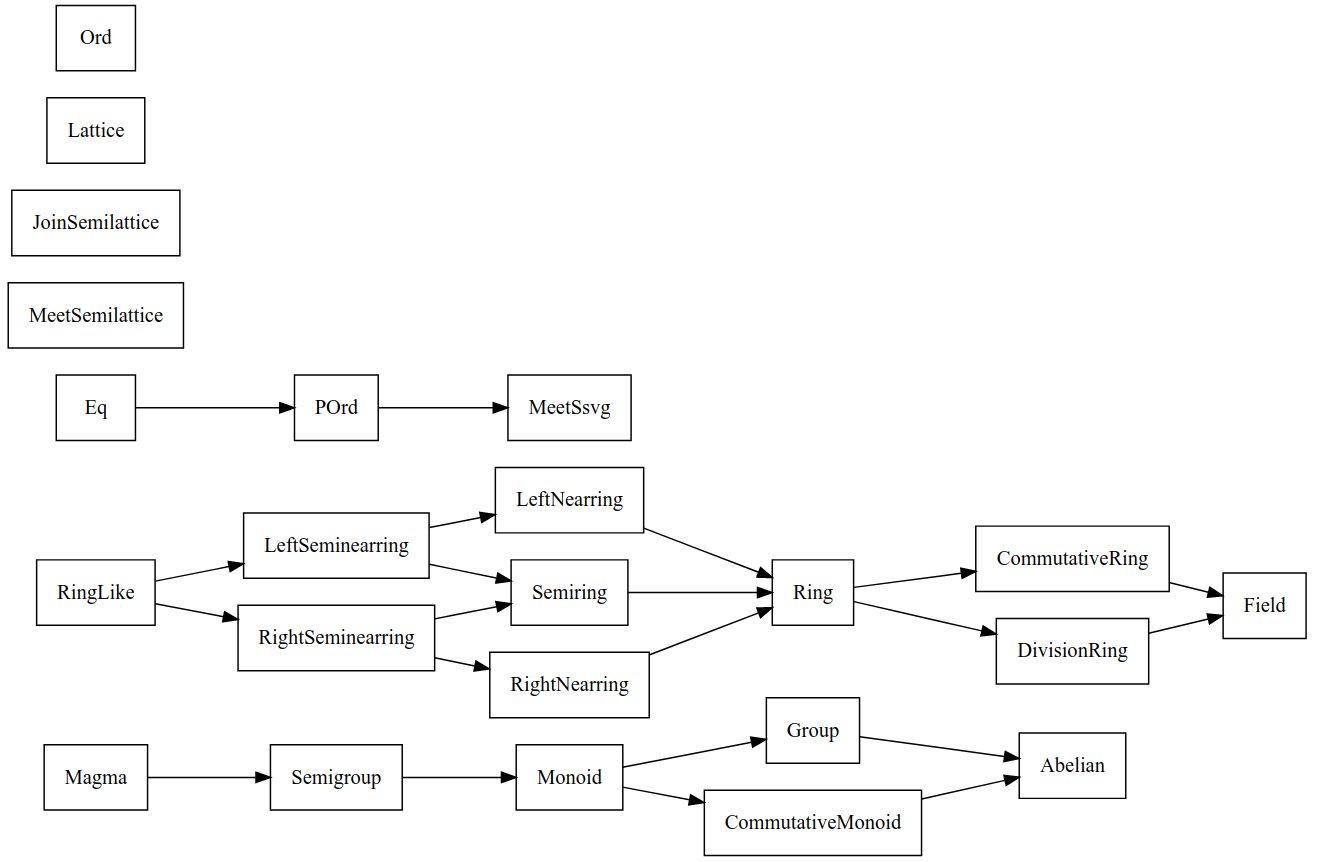

In [ ]:
ip.display.Image("img/scheme.png")

## foldr and foldl

- foldr - фолдим начиная с конца
- foldl - начиная с начала

```
foldr :: Foldable t => (a -> b -> b) -> b -> t a -> b
foldl :: Foldable t => (b -> a -> b) -> b -> t a -> b 
```

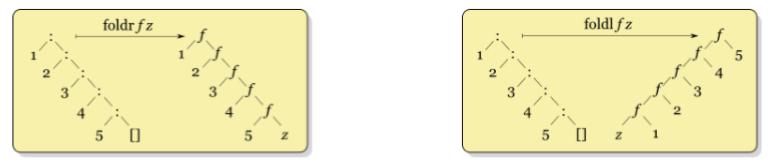

In [ ]:
ip.display.Image("img/fold.png")

Вопрос, который любят спрашивать на экзамене: сколько?

```
length (4, [1,2,3])
```
Ответ: 1, так как length определен через foldl следующим образом
```
length :: t a -> Int
length = foldl' (\c _ -> c+1) 0
```

Так как мы применяем функцию к частично примененной паре ((,) a) то inc выполнится лишь один раз
Типо как с Either. Получаеться, что t должно иметь kind *->*, а пара имеет *->*->*. И как бы применив fmap к паре мы применли fmap к (const, a)

Так же добавлю про разницу foldl и foldr из таблички:

> FOLDR из-за ленивости умеет не идти до конца
foldl идет с начала листа и сразу применяет функцию к эленту, тогда как foldr идет до конца и потом начинает принимать функцию. предположим что мы хотим вернуть Bool и у нас есть бесконечный список, имея операцию (&&) применяя к бесконечному листу с false в случае с foldl мы возвращаем аккамулятор в который аккамулируем инфинит лист. А в случае foldr мы сразу вернем результат False НООООО О foldr is often more efficient for lazy evaluation, so can be used with an infinite list as long as f is non-strict in its second argument (like (:) or (++)). порядок применения функции отличается, эффективнее foldr, т.к. он не спускается вниз перед вычислением
>


## Foldable type class


упрощенная версия :

```
class Foldable t where
    {-# MINIMAL foldMap | foldr #-}

    fold    :: Monoid m => t m -> m
    foldMap :: Monoid m => (a -> m) -> t a -> m
    foldr   :: (a -> b -> b) -> b -> t a -> b
```

## Functor

Залезет к тебе в трусы

Суть в том, что он позваляет применять функции к объектам в оберточки не разворачивая их

```
class Functor f where               -- f :: * -> *
    fmap :: (a -> b) -> f a -> f b
```

```
laws : 
1. fmap id      ≡ id
2. fmap (f . g) ≡ fmap f . fmap g
```

Кто это ваш \<\$\>

Так же через него очень удобно комбить функторы

```
infixl 4 <$>
(<$>) :: Functor f => (a -> b) -> f a -> f b
(<$>) = fmap


```


нужно упомянуть про Arrow Functor

Т.к. функции - first class obj => 
arrow определяет два типа и возвращает функцию
получаеться мы можем частично определить arrow

```
ghci> :kind (->)
(->) :: * -> * -> *
ghci> :kind (->) Int
(->) Int :: * -> *
```

```
instance Functor ((->) r)  where
    fmap :: (a -> b) -> (r -> a) -> r -> b
    fmap = (.)
ghci> let foo = fmap (+3) (+2)
ghci> foo 10
15
```

## Applicative

Делает вид, что на тебе нет трусов

По сути позволяет работать полностью через обертку

```
class Functor f => Applicative f where  -- f :: * -> *
    pure  :: a -> f a
    (<*>) :: f (a -> b) -> f a -> f b
```

```
laws:
1. identity
   pure id <*> v ≡ v

2. composition
   pure (.) <*> u <*> v <*> w ≡ u <*> (v <*> w)

3. homomorphism
   pure f <*> pure x ≡ pure (f x)

4. interchange
   u <*> pure y ≡ pure ($ y) <*> u
```

```
ghci> :t (+) <$> (+3) <*> (*100)
(+) <$> (+3) <*> (*100) :: (Num a) => a -> a

ghci> (+) <$> (+3) <*> (*100) $ 5
508

ghci> (\x y z -> [x,y,z]) <$> (+3) <*> (*2) <*> (/2) $ 5
[8.0,10.0,2.5]
```

нужно упомянуть про Arrow Applicative

```
instance Applicative ((->) r) where
    pure :: a -> r -> a
    pure x  = \_ -> x

    (<*>) :: (r -> a -> b) -> (r -> a) -> r -> b
    f <*> g = \x -> f x (g x)
```

## liftAN & Applicative style programming


По факту позволяет применить к обернутой функции несколько аргументов

## Alternative

Позваляет из нескольких получить какой то один.

```
class Applicative f => Alternative f where
    empty :: f a
    (<|>) :: f a -> f a -> f a
```

Пример на Maybe

Уловно вернуть не нулевое значение. При чем самое левое

```
instance Alternative Maybe where
    empty :: Maybe a
    empty = Nothing

    (<|>) :: Maybe a -> Maybe a -> Maybe a
    Nothing <|> r = r
    l       <|> _ = l
```

## List comprehension syntax sugar

Можем воспользоваться алтернативой так:

```
instance Alternative [] where
    empty :: [a]
    empty = []
    
    (<|>) :: [a] -> [a] -> [a]
    (<|>) = (++)
```


```
ghci> [] <|> [1,2,3] <|> [4]
[1,2,3,4]
```

## Traversable type class (and instances for Maybe, List)


Из лекции: как fold, только не дропает t

Как я понял: позваляет обернуть всю коллекцию в обертку


```
class (Functor t, Foldable t) => Traversable t where
    traverse  :: Applicative f => (a -> f b) -> t a -> f (t b)
    sequenceA :: Applicative f => t (f a) -> f (t a)
```

Пример для Maybe

```
instance Traversable Maybe where
    traverse :: Applicative f => (a -> f b) -> Maybe a -> f (Maybe b)
    traverse _ Nothing  = pure Nothing
    traverse f (Just x) = Just <$> f x
```

## Automatic deriving

Мы можем автоматически дерайвить Functor, Foldble, Traversble для сумм примитивов за исключением функций. С ними будет все плохо

- {-# LANGUAGE DeriveFunctor     #-}  -- generates `fmap`
- {-# LANGUAGE DeriveFoldable    #-}  -- generates `foldr` and `foldMap`
- {-# LANGUAGE DeriveTraversable #-}  -- generates `traverse`

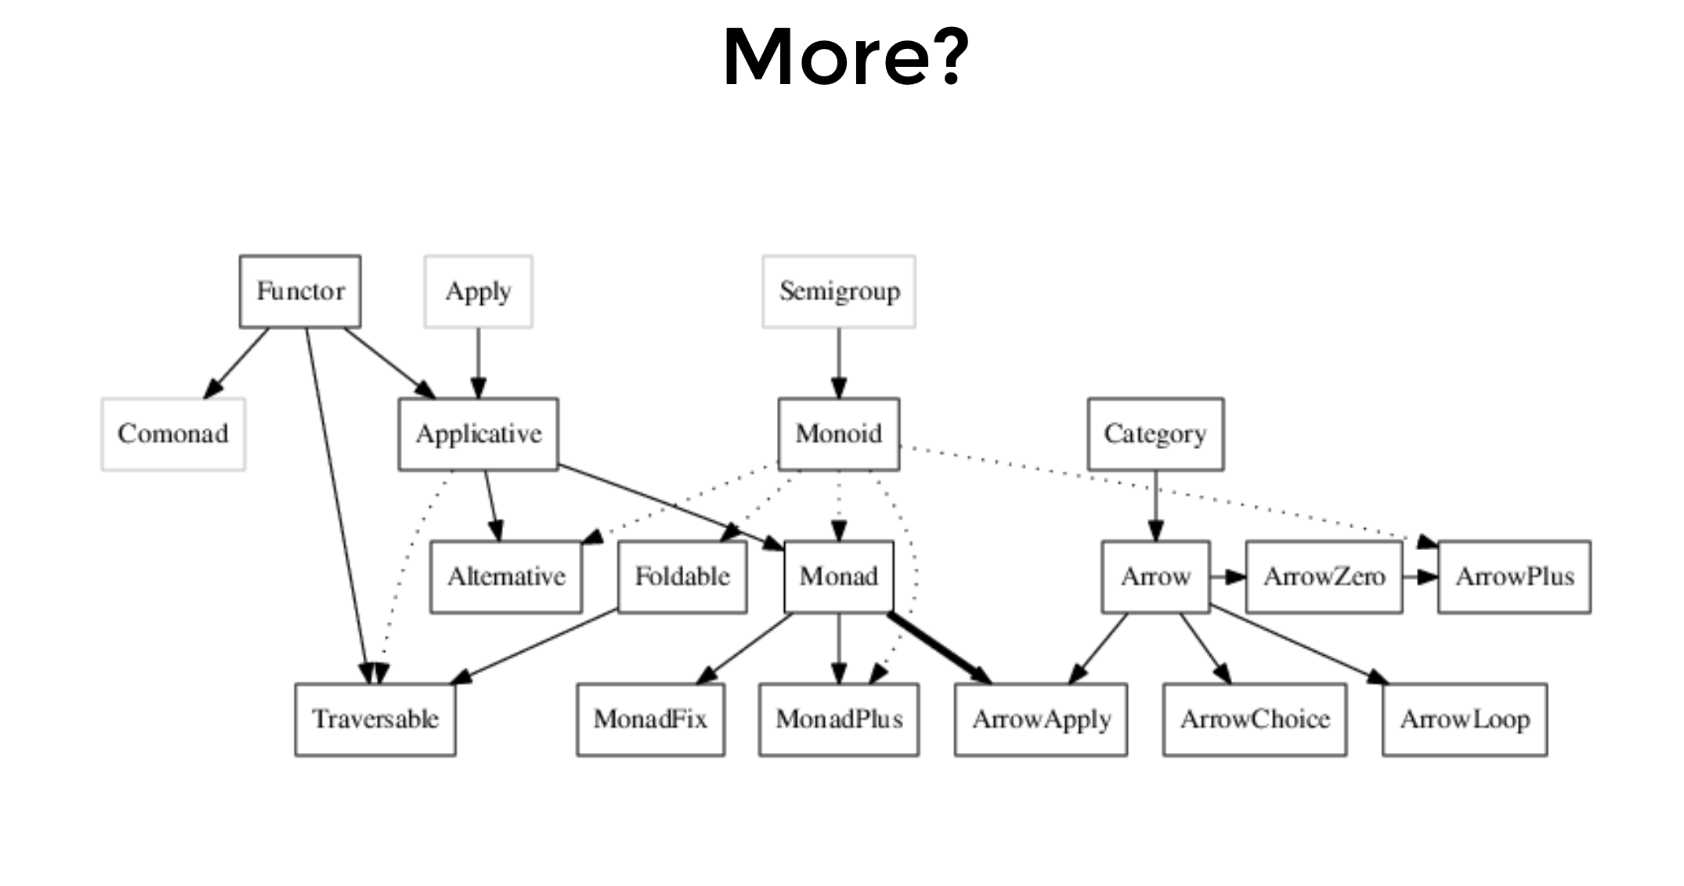

In [ ]:
ip.display.Image("img/irar.png")

## Phantom types

Позволяет усилить типизацию, хотя никак в самом типе не используеться напрямую

Проблема: 

```
newtype Hash = MkHash String
class Hashable a where
    hash :: a -> Hash
    
hashPair :: Int -> Hash
hashPair n = hash (n, n)

однако так же можно определить как: 

hashPair :: Int -> Hash
hashPair n = hash n  -- oops, this is valid definition!
```

Можем ввести фантомный тип, и тогда так сделать нельзя

```
newtype Hash a = MkHash String -- `a` is a phantom type, not present in constructor
class Hashable a where
    hash :: a -> Hash a
   
hashPair :: Int -> Hash (Int, Int)
hashPair n = hash (n, n)

hashPair :: Int -> Hash (Int, Int)
hashPair n = hash n  -- This is no longer a valid definition!
```

## Type extensions:

не всегда можно правильно вывести типы

```
-- v0.0.0: this compiles
prepend2 :: Int -> [Int] -> [Int]
prepend2 x xs = pairFun x ++ xs 
  where pairFun y = [y, y]
  
-- v1.0.0: also compiles
prepend2 :: Int -> [Int] -> [Int]
prepend2 x xs = pair ++ xs 
  where pair = [x, x]

-- v2.0.0: compiles or not?
prepend2 :: a -> [a] -> [a]
prepend2 x xs = pair ++ xs 
  where pair = [x, x]

-- v3.0.0: doesn't compile!
prepend2 :: a -> [a] -> [a]
prepend2 x xs = pair ++ xs 
  where pair :: [a]
        pair = [x, x]

-- v2.1.0: everything works!
prepend2 :: a -> [a] -> [a]
prepend2 x xs = pairFun x ++ xs 
  where pairFun :: a -> [a]
        pairFun y = [y, y]
```

v0.0.0: все работает, для всех правильно вычисляется тип

v1.0.0: аналогично

v2.0.0: все тоже работает, так как применив к конструктору List значения типа а мы даем понять компилятору, что у pair тип [a]

v3.0.0: не компилируется. здесь тип а в объявлении пары перекрывает тип а из объявления prepend2, соответственно ожидается, что pair - список любого типа. однако мы пытаемся определить его как список типа а из определения prepend2, который на данный момент уже зафиксирован.

v2.1.0 все хорошо. тип а из объявления pairFun все еще перекрывает аналогичный тип из объявления prepend2, но передав в pairFun x типа а из объявления prepend2 мы явно задали, что pairFun вернет список нужного нам типа


### XScopedTypeVariables

Под капотом любой полиморфизм имеет forall

Тогда наша функция будет выглядить : 

```
prepend2 :: forall a . a -> [a] -> [a]
prepend2 x xs = pair ++ xs 
  where 
    pair :: forall a . [a]
    pair = [x, x] 
```
Исправим:

```
{-# LANGUAGE ScopedTypeVariables #-}

prepend2 :: forall a . a -> [a] -> [a]
prepend2 x xs = pair ++ xs 
  where 
    pair :: [a]  -- uses same type variable 'a'
    pair = [x, x]
```

-XScopedTypeVariables language extension allows to use type variables from top-level function signature inside this function body (including where block). Works only with forall keyword!


### XTypeApplications

```
ghci> read "3"   :: Int  -- so, here we basically just pass Int type
3
ghci> read "3.0" :: Double
3.0
```

На самом деле read принимает не один аргумент

```
-- in some artifical syntax...
read :: (a :: Type) -> (_ :: String) -> (x :: a)
```

XTypeApplications позваляет передавать тип как аргумент

```
ghci> :t read
read :: Read a => String -> a
ghci> read @Int "3"
3
ghci> read @Double "3.0"
3.0
ghci> :t read @Int
read @Int :: String -> Int
```

### XAllowAmbiguousTypes

Вот так можем передавать тип в функцию для подстановки в полиморфные штуки

```
-- do you see problems with this code?
class Size a where
    size :: Int
    
-- simple plain haskell
class Size a where
    size :: a -> Int
```
с экстэншном
```
{-# LANGUAGE AllowAmbiguousTypes #-}

class Size a where size :: Int
instance Size Int    where size = 8
instance Size Double where size = 16


```

## Интересности

### With Maybe any Semigroup can be a Monoid

```
instance Semigroup a => Semigroup (Maybe a) where
    Nothing <> b       = b
    a       <> Nothing = a
    Just a  <> Just b  = Just (a <> b)

instance Semigroup a => Monoid (Maybe a) where
    mempty                    = Nothing
```

### Function is a Monoid


```
instance Monoid b => Monoid (a -> b) where
    mempty _ = mempty
    mappend f g x = f x `mappend` g x
```


### Monoid Ordering

```
data Ordering = LT | EQ | GT

instance Monoid Ordering where
    mempty         = EQ
    LT `mappend` _ = LT
    EQ `mappend` y = y
    GT `mappend` _ = GT
```

Зачем?

```
module Data.Ord (comparing, ...) where

comparing :: Ord a => (b -> a) -> b -> b -> Ordering
comparing p x y = compare (p x) (p y)
```
Мы можем делать лексиграфический порядок:
```
data ErrorPosition = ErrorPosition 
    { path   :: String
    , line   :: Int
    , offset :: Int 
    } deriving (Eq)

-- this implementation uses Monoid instances of (->) and Ordering
instance Ord ErrorPosition where
    compare = comparing path <> comparing line <> comparing offset
```


### Partial options monoid pattern

Какой-то еще способ круто использовать моноиды, который фпшники выдумали сами для себя чтобы оправдать свою нужность.

```
data Options = Options
  { oRetryCount    :: Int
  , oHost          :: String
  , oCharacterCode :: Maybe Char
  } deriving (Show, Eq)
```
Goal: we want to have options. We want to create multiple versions of records and combine them (defaults + file config + CLI)

Use monoid! (full details in blog post)
```
data PartialOptions = PartialOptions
   { poRetryCount    :: Last Int
   , poHost          :: Last String
   , poCharacterCode :: Last (Maybe Char)
   } deriving (Show, Eq)
   
instance Monoid PartialOptions where
    mempty = PartialOptions mempty mempty mempty
    mappend x y = PartialOptions 
        { poRetryCount    = poRetryCount    x <> poRetryCount    y
        , poHost          = poHost          x <> poHost          y
        , poCharacterCode = poCharacterCode x <> poCharacterCode y
        }
```

### много fmap

ибо можем
```
ghci> :t fmap
fmap :: Functor f => (a -> b) -> f a -> f b

ghci> :t fmap fmap
fmap fmap
  :: (Functor f, Functor f1) => f1 (a -> b) -> f1 (f a -> f b)

ghci> :t fmap fmap fmap
fmap fmap fmap
  :: (Functor f, Functor f1) => (a -> b) -> f1 (f a) -> f1 (f b)

ghci> :t fmap fmap fmap fmap
fmap fmap fmap fmap
  :: (Functor f, Functor f1, Functor f2) =>
     f2 (f1 (a -> b)) -> f2 (f1 (f a -> f b))

ghci> :t fmap fmap fmap fmap fmap
fmap fmap fmap fmap fmap
  :: Functor f => (a1 -> b) -> (a -> a1) -> f a -> f b
ghci> let fmap5 = fmap fmap fmap fmap fmap 
ghci> fmap5 (+1) (*2) [1..5]
[3, 5, 7, 9, 11]
```